In [10]:
# Estimation of Change in Price of Rice Commodity in India


# Importing all libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datetime import datetime
from pandas import Series
from pandas import DataFrame
from pandas import concat
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from pandas import read_csv
from numpy import set_printoptions
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
%matplotlib inline

pd.set_option('display.max_rows', None)

In [11]:
# Load food-prices dataset
df = pd.read_csv("wfp_market_food_prices.csv", encoding="latin-1")

# Drop unnecessary features
df.drop(['mp_commoditysource','cm_id','mkt_id','mkt_name','cur_id','pt_id','pt_name', 'um_id','um_name','adm0_id','adm1_id','adm1_name','cur_name'],inplace=True,axis=1)
 
# Consider only Rice commodity in India    
df = df[df.adm0_name == "India"]
df = df[df.cm_name =='Rice']



In [12]:
# Preprocessing of data

df['date'] = df.apply(lambda x: datetime(x['mp_year'],x["mp_month"],1),axis=1)
df = df.rename(columns={'mp_month':'month','mp_year':'year','mp_price':'price'})
df.drop(['adm0_name', 'cm_name'],inplace=True,axis=1)
df.index = np.arange(1, len(df) + 1)



In [15]:
# Feature Engineering

# Read carbon dioxide data
df_co2 = pd.read_csv("carbon_india.csv", sep=';')
# Merge co2 values into main dataframe
df = df.merge(df_co2.set_index('year'), on='year', how='left')

# Read temperature data
df_temp = pd.read_excel("temperature.xls")
df_temp = df_temp.rename(columns={' Month': 'month','\tYear':'year','tas':'temperature'})
df_temp['date'] = df_temp.apply(lambda x: datetime(int(x['year']),int(x['month']),1),axis=1)
df_temp.drop([' Country', 'month', 'year'],axis=1,inplace=True)
df = df.merge(df_temp.set_index('date'), on='date', how='left')

# Read inflation rate data
df_inf = pd.read_excel("inflation_rate_india.xls")
df = df.merge(df_inf.set_index('year'), on='year', how='left')

# Read consumer price index data
df_cpi = pd.read_excel("consumer_price_index_india.xls")
df = df.merge(df_cpi.set_index('year'), on='year', how='left')

# Read rainfall data
df_rain = pd.read_excel("rainfall.xls")
df_rain = df_rain.rename(columns={' Month': 'month','\tYear':'year','pr':'rainfall'})
df_rain['date'] = df_rain.apply(lambda x: datetime(int(x['year']),int(x['month']),1),axis=1)
df_rain.drop([' Country', 'month', 'year'],axis=1,inplace=True)
df = df.merge(df_rain.set_index('date'), on='date', how='left')



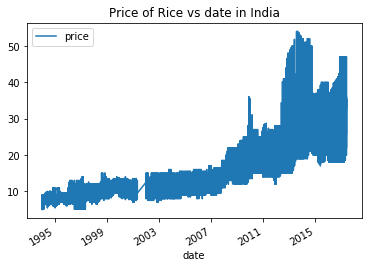

In [16]:
# Plot price versus date
dfp = pd.DataFrame(pd.Series(data=df.loc[:,'price'].values).values,columns=['price'],index=df['date'])
dfp.plot()
plt.title("Price of Rice vs date in India")
plt.show()

In [17]:
# Calculate 3 month mean of price
width = 3
lag1 = dfp.shift(1)
lag3 = dfp.shift(width - 1)
window = lag1.rolling(window=width)
df3 = concat([window.mean()], axis=1)
df3.columns = ['3 month mean price']
df['3 month mean'] = df3.values

# Calculate 6 month mean of price
width = 6
lag1 = dfp.shift(1)
lag3 = dfp.shift(width - 1)
window = lag1.rolling(window = width)
df6 = concat([window.mean()], axis=1)
df6.columns = ['6 month mean price']
df['6 month mean'] = df6.values

# Calculate 9 month mean of price
width = 9
lag1 = dfp.shift(1)
lag3 = dfp.shift(width - 1)
window = lag1.rolling(window=width)
df9 = concat([window.mean()], axis=1)
df9.columns = ['9 month mean price']
df['9 month mean'] = df9.values

# Calculate 12 month mean of price
width = 12
lag1 = dfp.shift(1)
lag3 = dfp.shift(width - 1)
window = lag1.rolling(window=width)
df12 = concat([window.mean()], axis=1)
df12.columns = ['12 month mean price']
df['12 month mean'] = df12.values

df.dropna(axis=0,inplace=True)


In [9]:
# Description of dataset

actual_df = df
print('Shape:',df.shape)
print('\nColumns:',df.columns)
print('\nDatatypes:',df.dtypes)
display(df.describe(include="all").T)

Shape: (7369, 13)

Columns: Index(['month', 'year', 'price', 'date', 'co2', 'temperature', 'inflation',
       'consumer_price_index', 'rainfall', '3 month mean', '6 month mean',
       '9 month mean', '12 month mean'],
      dtype='object')

Datatypes: month                            int64
year                             int64
price                          float64
date                    datetime64[ns]
co2                            float64
temperature                    float64
inflation                      float64
consumer_price_index           float64
rainfall                       float64
3 month mean                   float64
6 month mean                   float64
9 month mean                   float64
12 month mean                  float64
dtype: object


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
month,7369,NaN,NaN,NaN,NaN,NaN,6.34957,3.45169,1,3,6,9,12
year,7369,NaN,NaN,NaN,NaN,NaN,2008.87,6.64557,1994,2004,2011,2014,2017
price,7369,NaN,NaN,NaN,NaN,NaN,19.6229,8.46939,5,11.75,20,26,54
date,7369,275,2017-01-01 00:00:00,59,1994-01-01 00:00:00,2017-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
co2,7369,NaN,NaN,NaN,NaN,NaN,1744.13,558.945,764.11,1153.38,1840.27,2236.55,2500
temperature,7369,NaN,NaN,NaN,NaN,NaN,25.4841,4.52443,16.0098,21.7733,26.57,29.1176,31.08
inflation,7369,NaN,NaN,NaN,NaN,NaN,7.15222,2.78639,3.38,4.907,6.658,9.312,13.321
consumer_price_index,7369,NaN,NaN,NaN,NaN,NaN,104.009,40.8329,34.13,63.14,108.85,140.76,160.13
rainfall,7369,NaN,NaN,NaN,NaN,NaN,85.1589,89.7282,1.06062,16.2915,41.1564,149.317,320.146
3 month mean,7369,NaN,NaN,NaN,NaN,NaN,19.6173,8.39531,5.05,11.6667,19.8333,26,53.89


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012DC0A35BA8>,
      dtype=object)

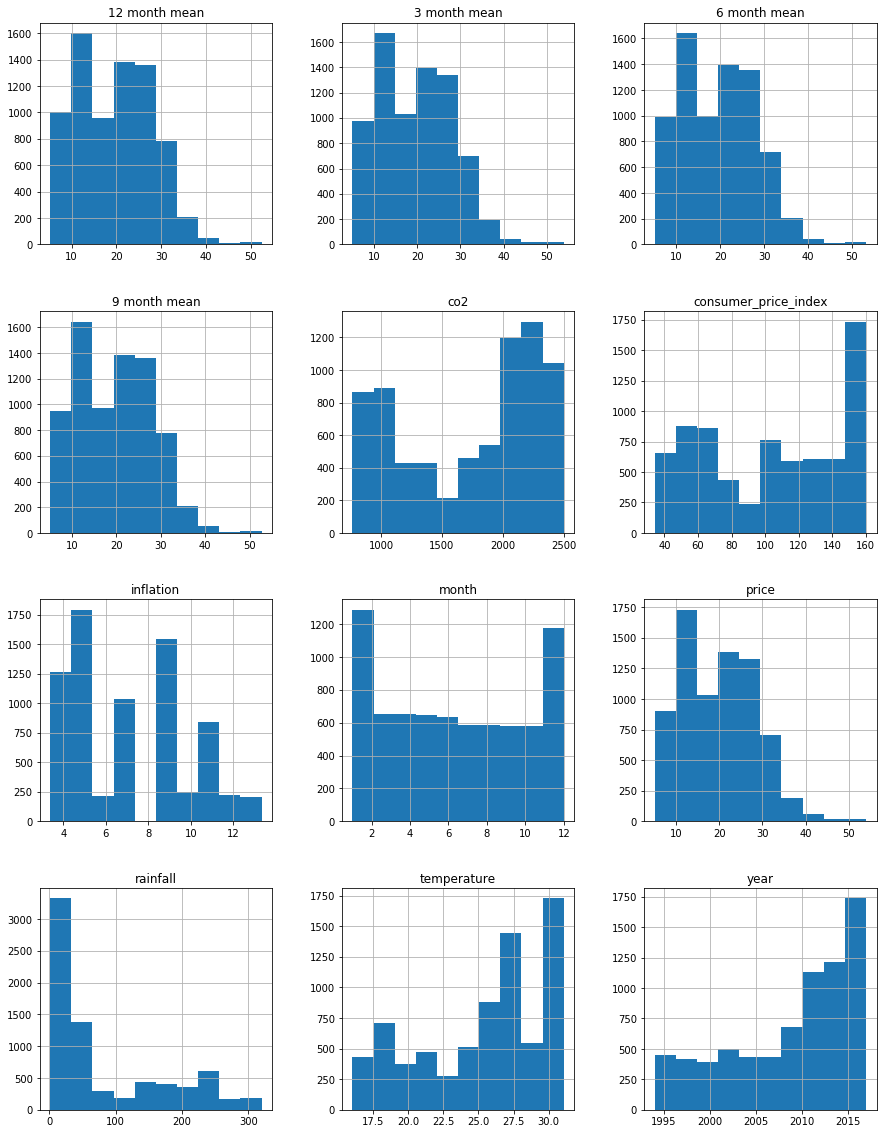

In [11]:
# Plot histogram of dataset

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax=ax)

In [6]:
# Calculate qcut which will be a label to indicate the percentage change in price

qcut = pd.qcut((df.price.sort_values(ascending=True).values), 10,labels=[1,2,3,4,5,6,7,8,9,10])
print(qcut)
df.sort_values(by=['price'], inplace=True)
df['label'] = qcut
df.sort_index(inplace=True)
df.dropna(axis=0,inplace=True)



[1, 1, 1, 1, 1, ..., 10, 10, 10, 10, 10]
Length: 7381
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]


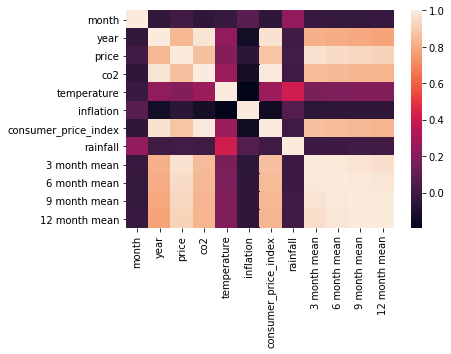

In [13]:
# Plot correlation matrix plot

correlations = df.corr()
sns.heatmap(correlations, xticklabels=correlations.columns.values, yticklabels=correlations.columns.values)

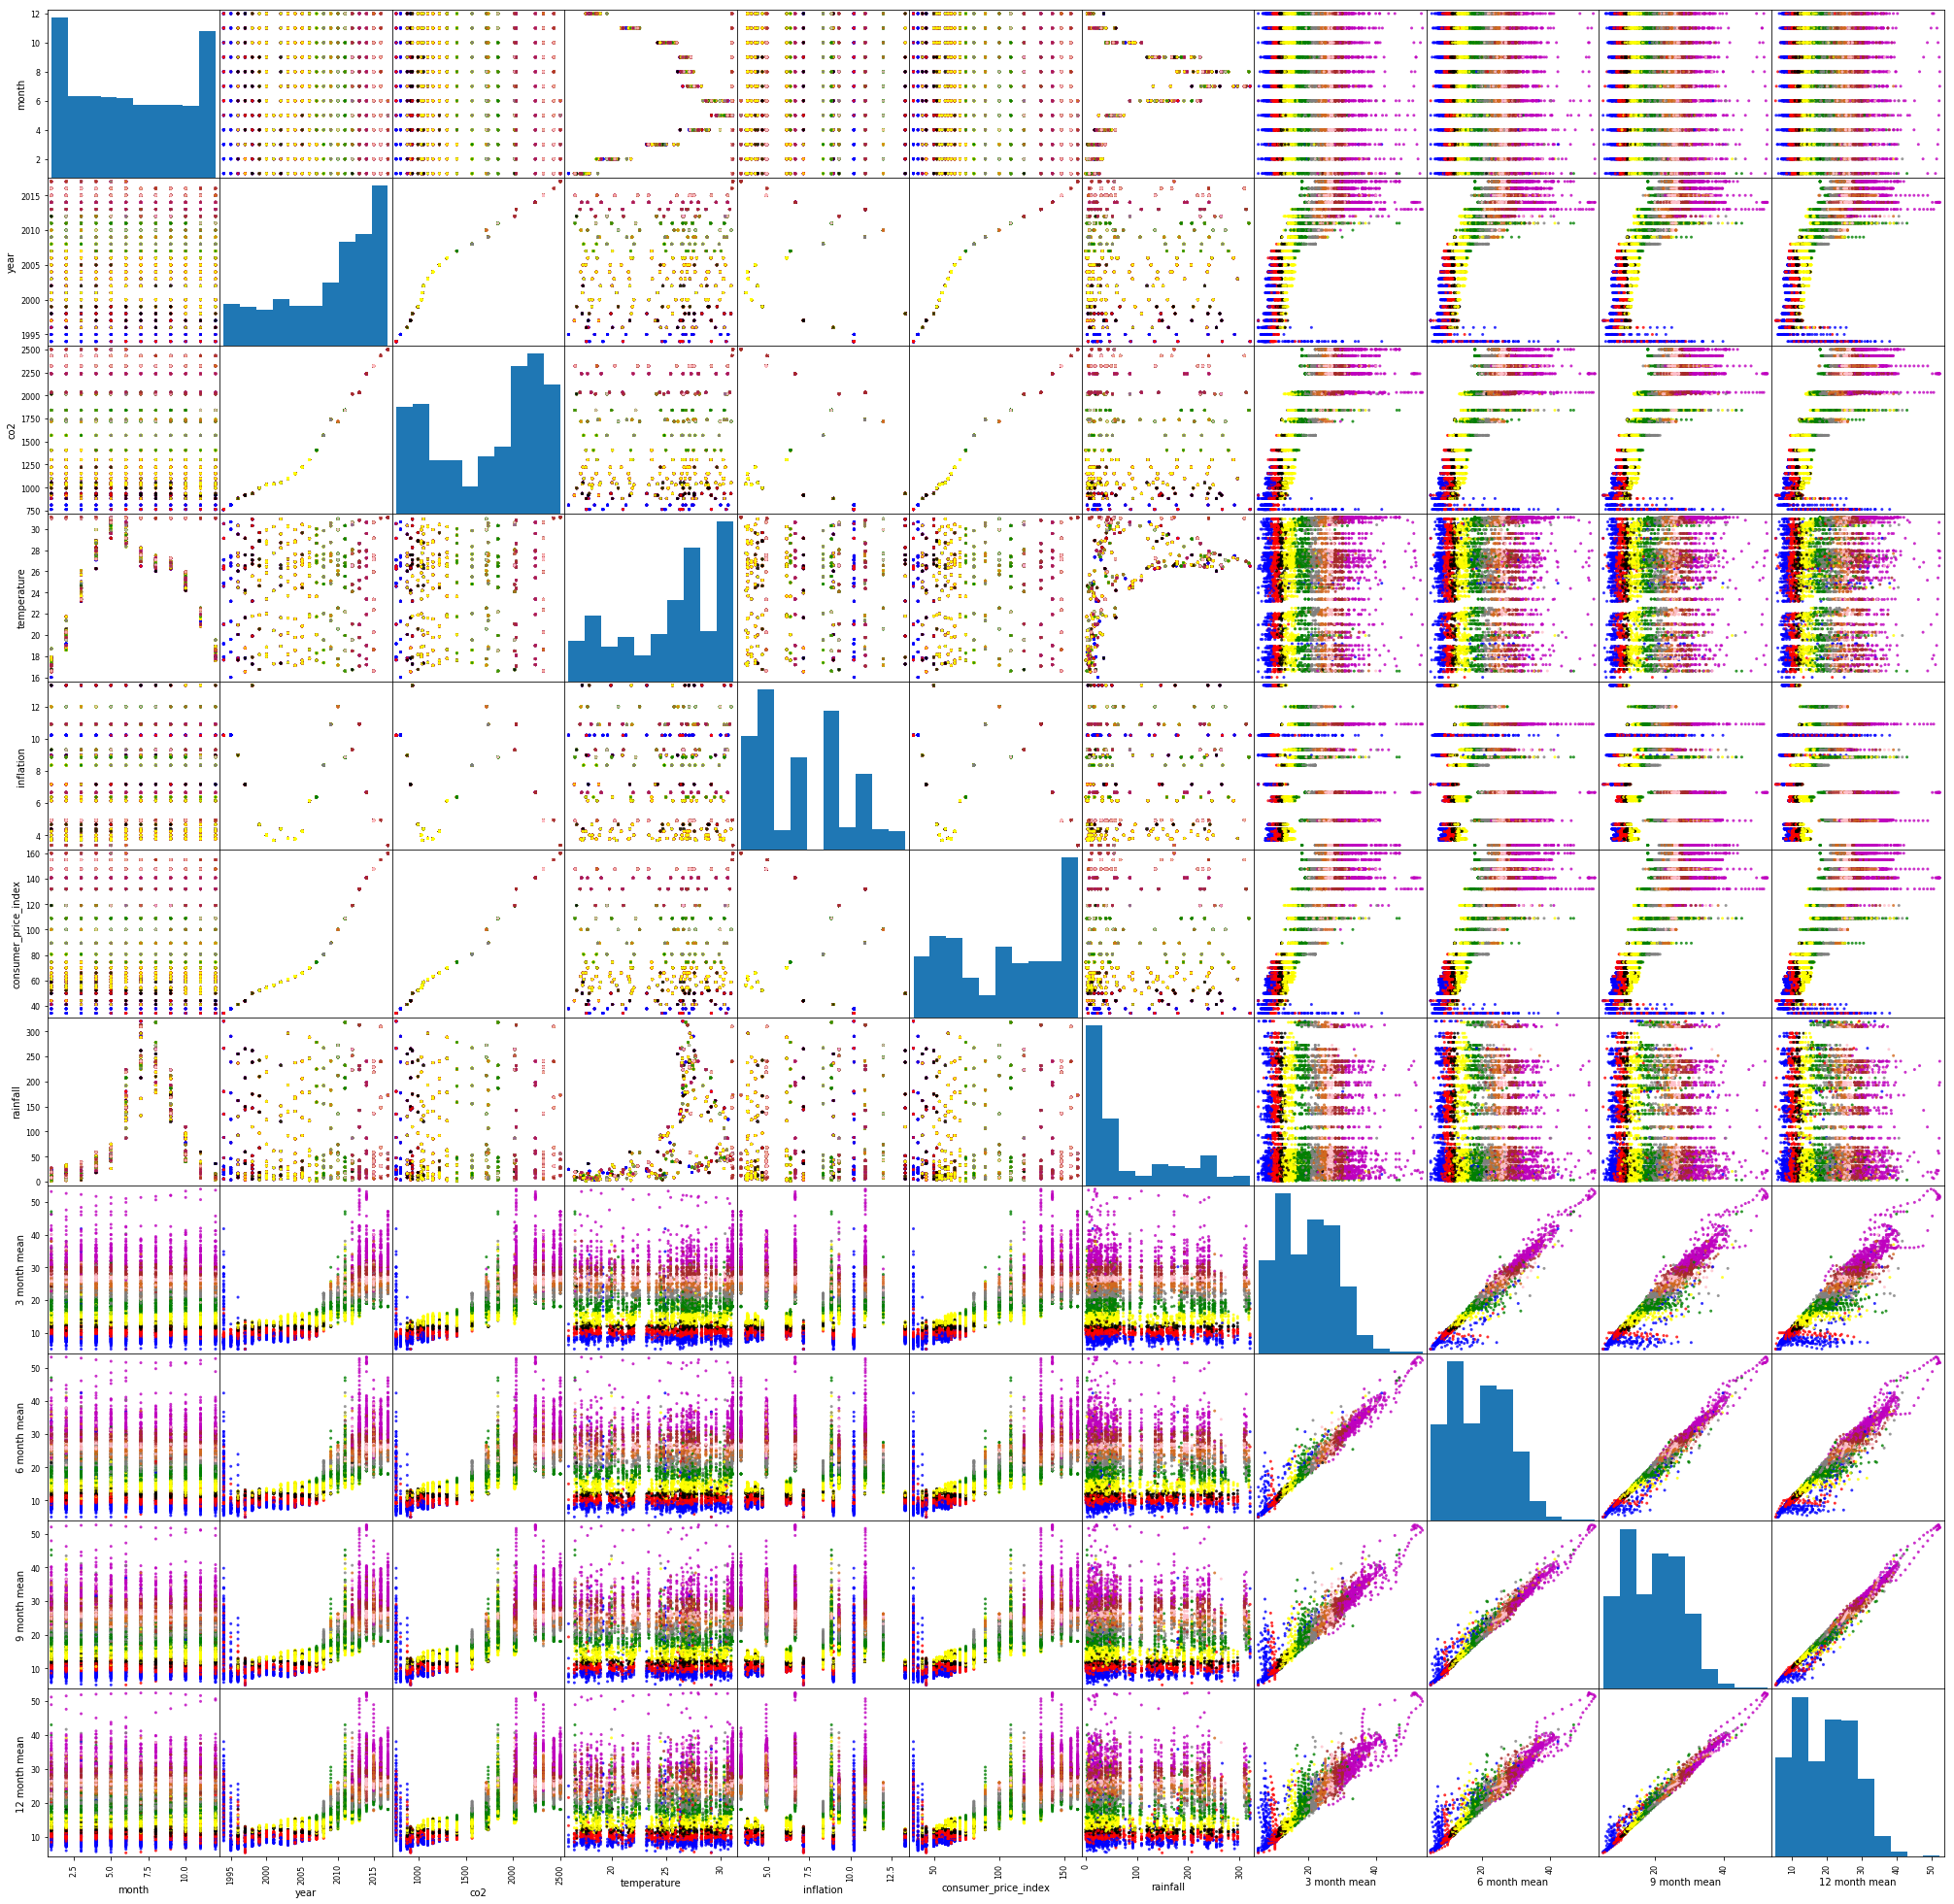

In [14]:
# Plot scatter matrix of the dataset

df.drop(columns=['date','price'],inplace=True)
palette = {1 : 'blue', 2 : 'red',3:'black',4:'yellow',5:'green',6:'gray',7:'chocolate',8:'pink',9:'brown',10:'m'}
labels=df['label']
labels_c = list(map(lambda x: palette[int(x)], labels))
grr = pd.plotting.scatter_matrix(df,figsize=(35,35), alpha=0.8, c=labels_c)

In [16]:
#Standardizing data for Gaussian distribution

array = df.values
# separate array into input and output components
cols = 11
X = array[:,:cols]
Y = array[:,cols]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# summarize transformed data
np.set_printoptions(precision=3)
print(X[0:5,:])

# split train and test data
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')
actual = Y_test

[[-1.26  -1.786 -1.48  -1.483  0.004 -1.471 -0.906 -1.344 -1.317 -1.326
  -1.345]
 [-0.97  -1.786 -1.48  -0.337  0.004 -1.471 -0.772 -1.364 -1.327 -1.329
  -1.34 ]
 [-0.681 -1.786 -1.48   0.169  0.004 -1.471 -0.523 -1.344 -1.337 -1.329
  -1.34 ]
 [-0.391 -1.786 -1.48   0.803  0.004 -1.471 -0.491 -1.304 -1.337 -1.329
  -1.338]
 [-0.101 -1.786 -1.48   0.799  0.004 -1.471  0.715 -1.285 -1.337 -1.329
  -1.335]]


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
# Gaussian NB model

Y = Y.astype('int')
kfold = KFold(n_splits=10, random_state=7)
model = GaussianNB()
model.fit(X_train,Y_train)
results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
print('Gaussian NB model Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation=',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Gaussian NB model Accuracy:
Mean= 62.952 %	Std deviation= 5.199 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.849057  0.54      0.660147        250
   0.674129  0.818731  0.739427        331
   0.528926  0.825806  0.644836        155
   0.746914  0.461832  0.570755        262
   0.625731  0.730375  0.674016        293
   0.559585  0.404494  0.469565        267
   0.484429  0.608696  0.539499        230
   0.450292  0.442529  0.446377        174
   0.633758  0.802419  0.708185        248
   0.873418  0.621622  0.726316        222


In [18]:
# Decision Tree Classifier model

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
kfold = KFold(n_splits=10, random_state=7)
model = DecisionTreeClassifier()
model.fit(X_train,Y_train)
results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
print('Decision Tree Classifier Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Decision Tree Classifier Accuracy:
Mean= 68.354 %	Std deviation=  3.637 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.818584  0.74      0.777311        250
   0.727794  0.767372  0.747059        331
   0.616438  0.580645  0.598007        155
   0.758865  0.816794  0.786765        262
   0.785714  0.788396  0.787053        293
   0.707317  0.651685  0.678363        267
   0.620087  0.617391  0.618736        230
   0.613402  0.683908  0.646739        174
   0.726908  0.729839  0.72837         248
   0.820276  0.801802  0.810934        222


In [19]:
# SVC model

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
model = SVC()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X_train, Y_train)
print(grid.best_params_)
print('SVC model Accuracy:',grid.best_score_*100)

prediction = grid.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC model Accuracy: 76.88879886570791

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.88835   0.732     0.802632        250
   0.76781   0.879154  0.819718        331
   0.769737  0.754839  0.762215        155
   0.821561  0.843511  0.832392        262
   0.812057  0.78157   0.796522        293
   0.735178  0.696629  0.715385        267
   0.649402  0.708696  0.677755        230
   0.678788  0.643678  0.660767        174
   0.733096  0.830645  0.778828        248
   0.907216  0.792793  0.846154        222


In [20]:
# Logistic Regression model

kfold = KFold(n_splits=10, random_state=7)
model = LogisticRegression()
model.fit(X_train,Y_train)
results = cross_val_score(model, X, Y, cv=kfold)
print('Logistic Regression model Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Logistic Regression model Accuracy:
Mean= 45.922 %	Std deviation=  6.39 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.644737  0.588     0.615063        250
   0.485944  0.731118  0.583836        331
   0         0         0               155
   0.362264  0.366412  0.364326        262
   0.434615  0.771331  0.555966        293
   0.490909  0.202247  0.286472        267
   0.342857  0.156522  0.214925        230
   0         0         0               174
   0.405896  0.721774  0.519594        248
   0.770751  0.878378  0.821053        222


In [21]:
# Linear Discrimination model

num_folds = 10
kfold = KFold(n_splits=10, random_state=7)
model = LinearDiscriminantAnalysis()
model.fit(X_train,Y_train)
results = cross_val_score(model,X, Y, cv=kfold)
print('Linear Discrimination model Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Linear Discrimination model Accuracy:
Mean= 51.744 %	Std deviation=  4.474 %

   precision     recall    fscore    support
-----------  ---------  --------  ---------
   0.560137  0.652      0.602588        250
   0.51      0.616314   0.55814         331
   0.230769  0.0967742  0.136364        155
   0.505208  0.370229   0.427313        262
   0.555838  0.74744    0.637555        293
   0.369792  0.265918   0.309368        267
   0.456835  0.552174   0.5             230
   0.525773  0.293103   0.376384        174
   0.600559  0.866935   0.709571        248
   0.921212  0.684685   0.78553         222


D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [22]:
# KNeighborsClassifier model

num_folds = 10
kfold = KFold(n_splits=10, random_state=7)
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train,Y_train)
results = cross_val_score(model, X, Y, cv=kfold)
print('KNeighborsClassifier model Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

KNeighborsClassifier model Accuracy:
Mean= 63.129 %	Std deviation=  3.599 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.743961  0.616     0.673961        250
   0.582589  0.78852   0.67009         331
   0.5       0.303226  0.37751         155
   0.694561  0.633588  0.662675        262
   0.629179  0.706485  0.665595        293
   0.556017  0.501873  0.527559        267
   0.454225  0.56087   0.501946        230
   0.5       0.33908   0.40411         174
   0.623333  0.754032  0.682482        248
   0.860465  0.666667  0.751269        222


In [23]:
# Bagging Classifier model

seed = 7
kfold = KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 130
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees,max_features = 5, random_state=seed) 
model.fit(X_train,Y_train)
results = cross_val_score(model, X, Y, cv=kfold)
print('Bagging Classifier Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Bagging Classifier Accuracy:
Mean= 75.424 %	Std deviation=  2.271 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.868644  0.82      0.843621        250
   0.792507  0.830816  0.811209        331
   0.742857  0.670968  0.705085        155
   0.8125    0.89313   0.850909        262
   0.8157    0.8157    0.8157          293
   0.746888  0.674157  0.708661        267
   0.663934  0.704348  0.683544        230
   0.692308  0.672414  0.682216        174
   0.745455  0.826613  0.783939        248
   0.894472  0.801802  0.845606        222


In [24]:
# Random forest classifier model

num_trees = 150
max_features = 6
kfold = KFold(n_splits=10, random_state=7)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features) 
model.fit(X_train, Y_train)
results = cross_val_score(model, X, Y, cv=kfold)
print('Random forest classifier Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Random forest classifier Accuracy:
Mean= 77.731 %	Std deviation=  2.442 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.869748  0.828     0.848361        250
   0.8       0.833837  0.816568        331
   0.730496  0.664516  0.695946        155
   0.826241  0.889313  0.856618        262
   0.844595  0.853242  0.848896        293
   0.800885  0.677903  0.73428         267
   0.674419  0.756522  0.713115        230
   0.691011  0.706897  0.698864        174
   0.762846  0.778226  0.770459        248
   0.874419  0.846847  0.860412        222


In [25]:
# Gradient Boosting Classifier model

seed = 7
num_trees = 100
kfold = KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed) 
model.fit(X_train,Y_train)
results = cross_val_score(model, X, Y, cv=kfold)
print('Gradient Boosting Classifier Accuracy:\nMean=',round(results.mean()*100,3), '%\tStd deviation= ',round(results.std()*100,3), '%')

prediction = model.predict(X_test)
precision,recall,fscore,support = metrics.precision_recall_fscore_support(actual,prediction,average=None)
results = {"precision":precision,"recall":recall,"fscore":fscore,"support" : support}
print("\n",tabulate(results,headers="keys"))

Gradient Boosting Classifier Accuracy:
Mean= 78.423 %	Std deviation=  2.679 %

   precision    recall    fscore    support
-----------  --------  --------  ---------
   0.882096  0.808     0.843424        250
   0.788301  0.854985  0.82029         331
   0.774436  0.664516  0.715278        155
   0.816901  0.885496  0.849817        262
   0.857143  0.83959   0.848276        293
   0.784483  0.681648  0.729459        267
   0.660079  0.726087  0.691511        230
   0.674033  0.701149  0.687324        174
   0.742424  0.790323  0.765625        248
   0.857143  0.810811  0.833333        222



Feature importances: [0.026 0.014 0.02  0.054 0.034 0.014 0.053 0.357 0.155 0.117 0.157]


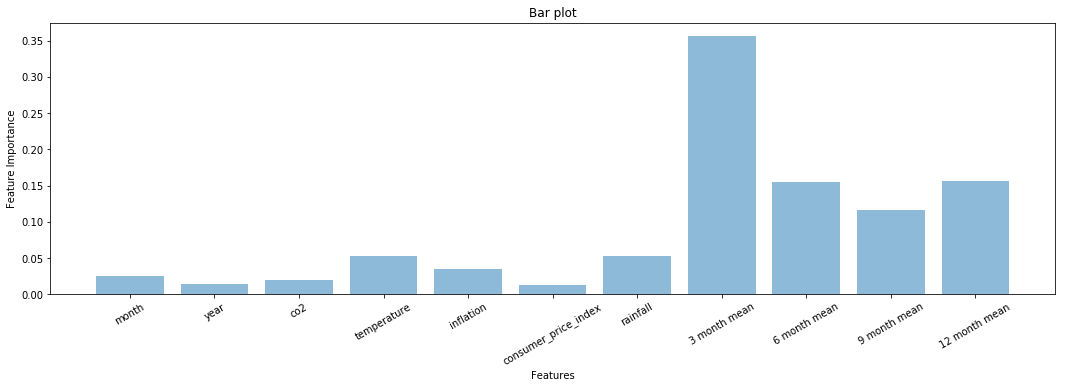

In [26]:
# Feature importances for Gradient Boosting Classifier model

print('\nFeature importances:',model.feature_importances_)
y_pos = np.arange(cols)
x = model.feature_importances_
f, ax = plt.subplots(figsize=(18,5))
plt.bar(y_pos, x, width=0.8,align='center', alpha=0.5)
plt.title('Bar plot')
plt.xticks(y_pos, df.columns,fontsize=10,rotation=30)
plt.ylabel('Feature Importance')
plt.xlabel('Features')
plt.show()